# Fisher Analysis
In this notebook we explore the Fisher metric with quantized models.

In [10]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import pickle
import ast
import os
import sys
from statistics import mean

# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from fisher import FIT



## Utility methods

In [11]:
def plot_2d_heatmap(values, 
                    title, 
                    min_max=(0, 1), 
                    x_label='Layers', 
                    y_label='Layers', 
                    scale_label='Value', 
                    cmap='Greens',
                    show_value=True):
    '''
    Method used to plot a 2D heatmap using Seaborn.
    '''
    # Set up the figure and axes
    plt.figure(figsize=(7, 6))

    # Create a heatmap using Seaborn
    sns.heatmap(values, 
                cmap=cmap, 
                annot=show_value, 
                fmt=".2f", 
                vmin=min_max[0], 
                vmax=min_max[1],
                cbar_kws={'label': scale_label})

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()
    
def plot_fisher_trace_per_layer(value, 
                                title, 
                                x_label='Layers', 
                                y_label='Fisher trace'):
    plt.figure(figsize=(12,6))
    
    plt.bar(value.keys(), 
            value.values())

    plt.ylim(0, 1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Display the plot
    plt.show()

In [12]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# ECON model (Autoencoder)
we focus our analysis on the encoder which will be deploy on an ASIC.

In [13]:
DATA_PATH = '/data/tbaldi/work/checkpoint/'
DATASET_DIR = '../../data/ECON/Elegun'
DATASET_FILE = 'nELinks5.npy'

size = 'baseline'

In [14]:
def read_file(file_path, name='fisher'):
    
    file_path = os.path.join(file_path, f'{name}.pkl')
    
    try:
        with open(file_path, 'rb') as f:
            result = pickle.load(f)
        return result[name]
    except FileNotFoundError:
        print(f"File not found. ({file_path})")
    except Exception as e:
        print("Error occurred:", e)

## Results

Neural efficiency require to process an input sample per time. 

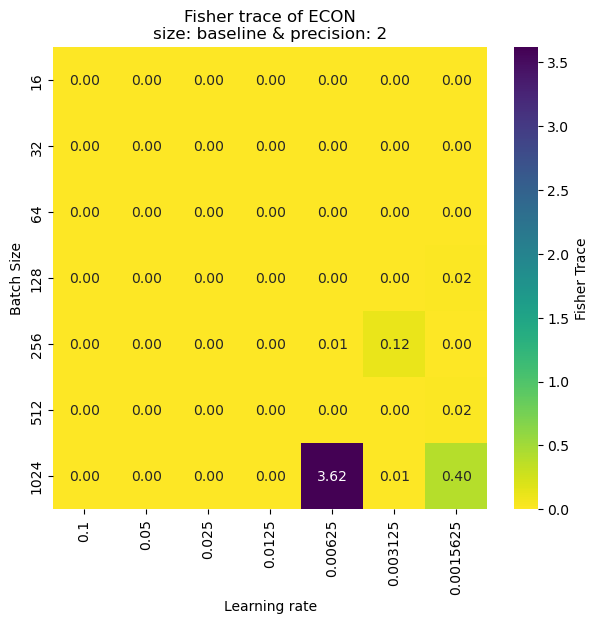

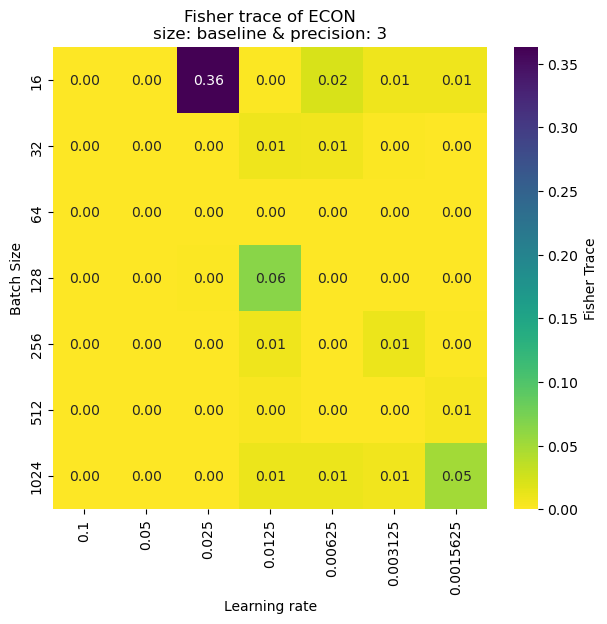

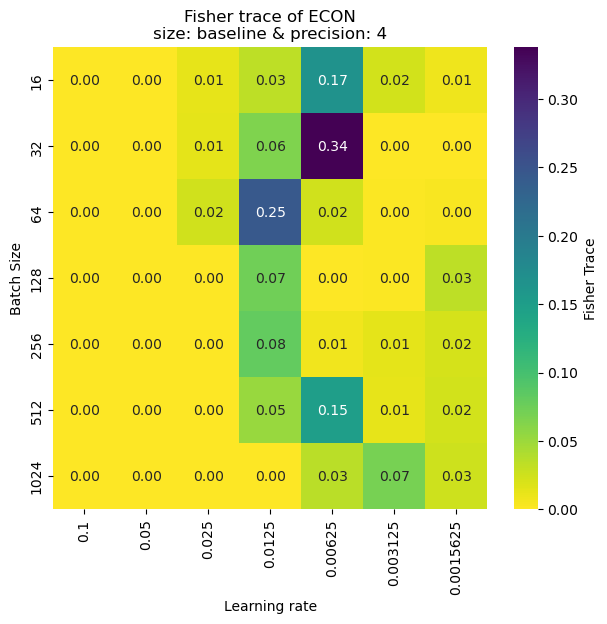

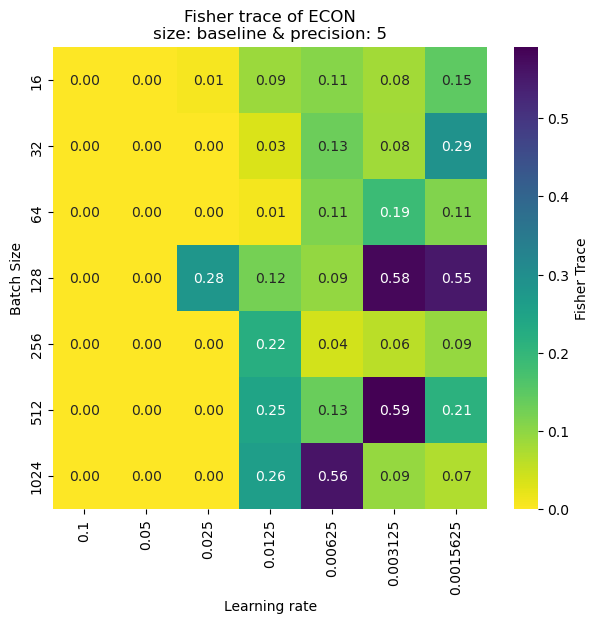

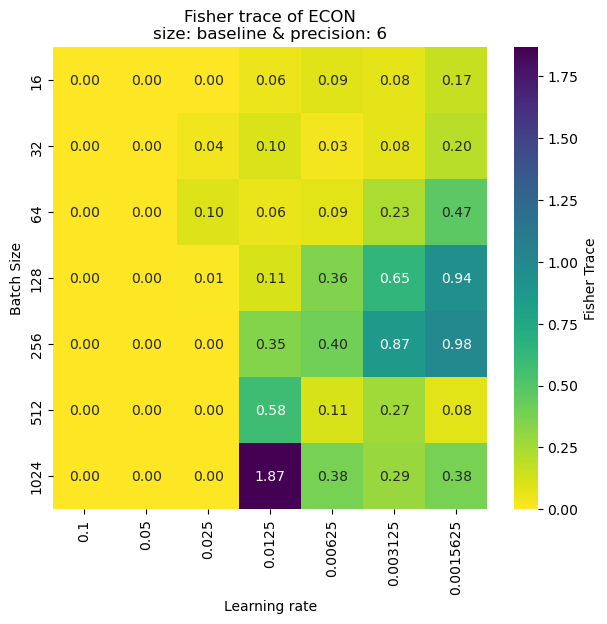

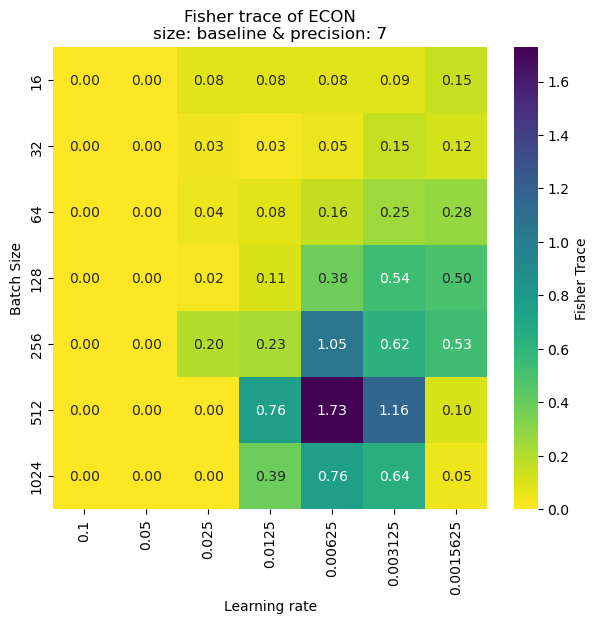

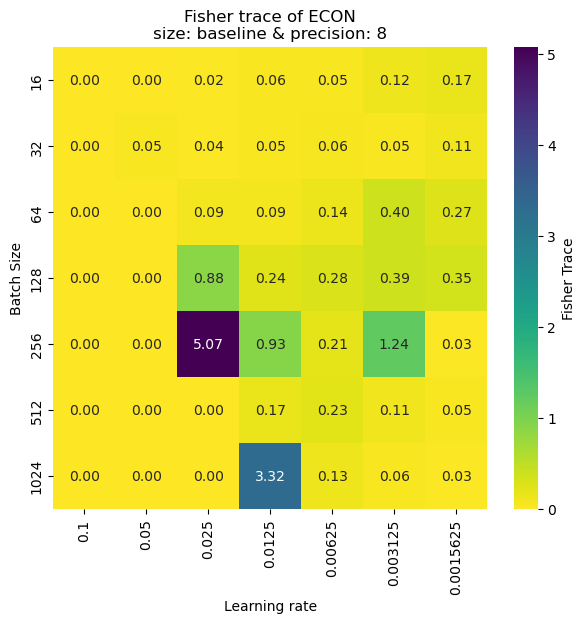

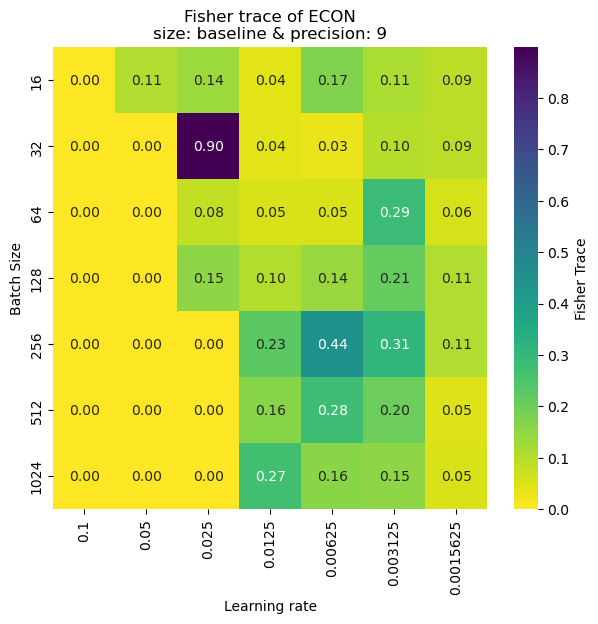

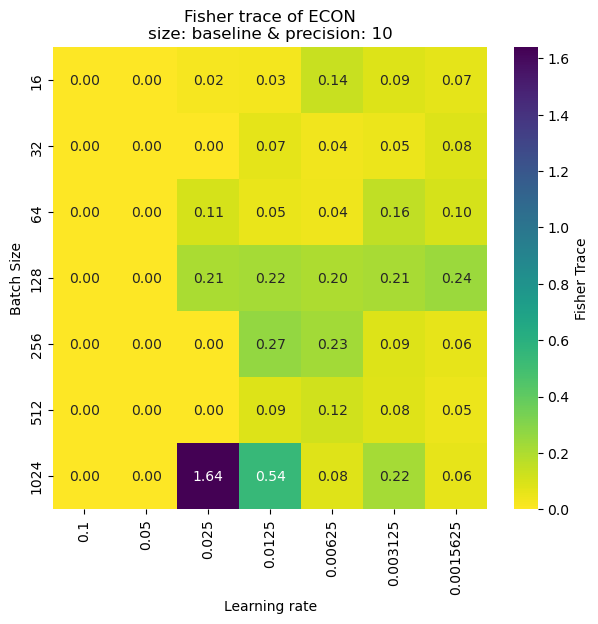

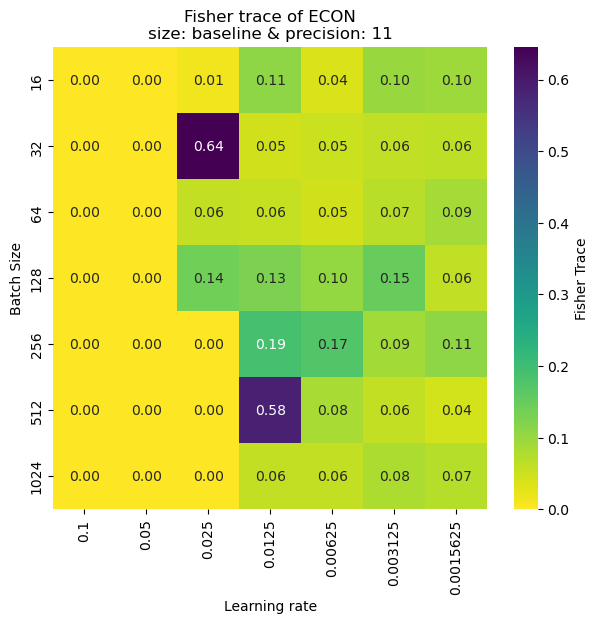

In [15]:
fisher_distribution = []
for p in precisions:
    fisher_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            # load the value from the file
            path = os.path.join(
                DATA_PATH, 
                f'bs{bs}_lr{lr}/ECON_{p}b/{size}/'
            )
            result = -1
            try:
                result = read_file(path)
            except:
                print("Error: cannot open the file!")

            
            # build the heatmap matrix
            fisher_matrix[x, y] = result['avg_EF']
            
            # build the dataframe for further analysis
            fisher_distribution.append({
                'precision': p, 
                'avg_EF': result['avg_EF'],
                'batch_size': str(bs),
                'learning_rate': str(lr),
            })
            
    # plot the heatmaps per precision
    fisher_matrix = pd.DataFrame(fisher_matrix, 
                                 index=batch_sizes, 
                                 columns=learning_rates)
    plot_2d_heatmap(fisher_matrix, 
                    f'Fisher trace of ECON\nsize: {size} & precision: {p}', 
                    (0, fisher_matrix.max().max()),
                    'Learning rate',
                    'Batch Size',
                    'Fisher Trace',
                    cmap='viridis_r')
    

In [16]:
fisher_distribution_df = pd.DataFrame(fisher_distribution)
# eport to CSV
fisher_distribution_df.to_csv("./results/econ/fisher.csv", index=False)

# RN08 (ResNet)

In [17]:
DATA_PATH="/data/tbaldi/work/checkpoint/"   
DATASET_DIR = "/data/tbaldi/work/loss_landscape_taxonomy/data/RN08/"

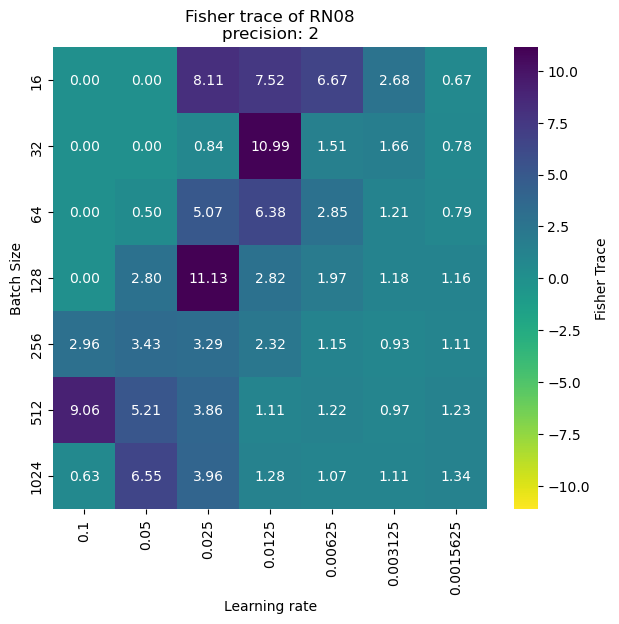

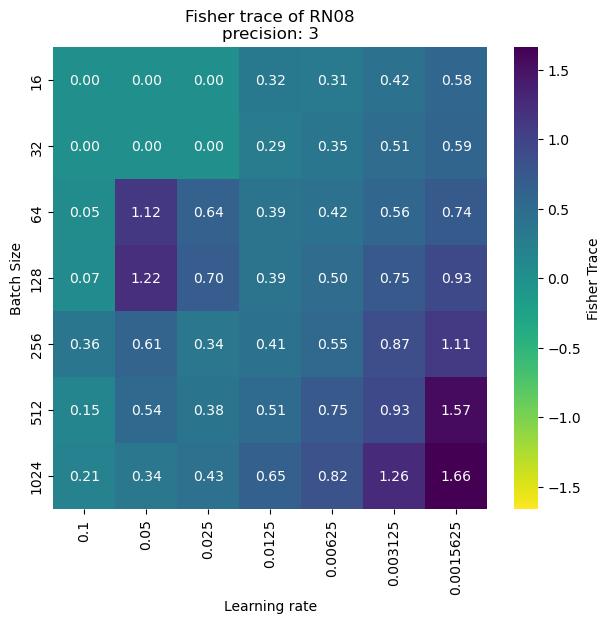

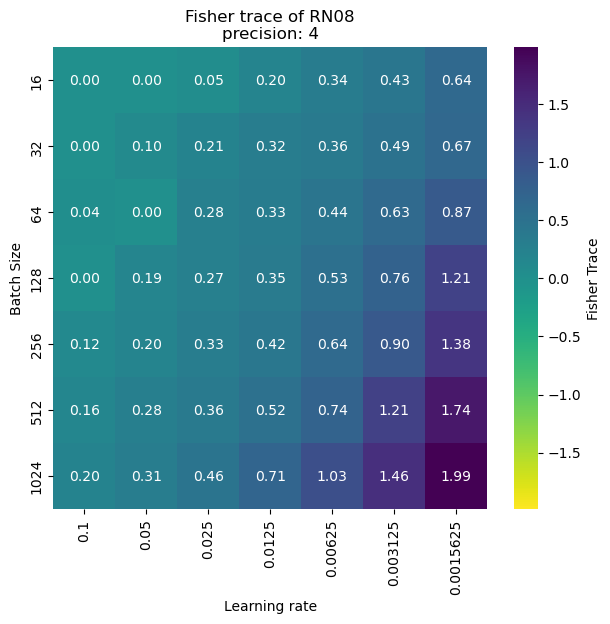

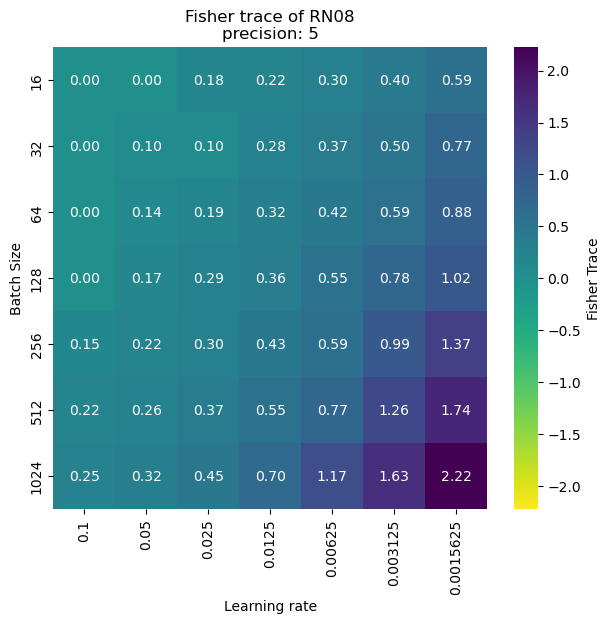

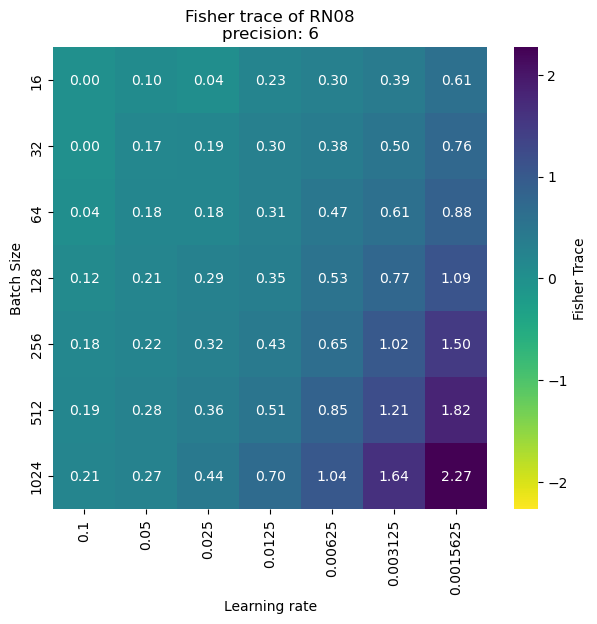

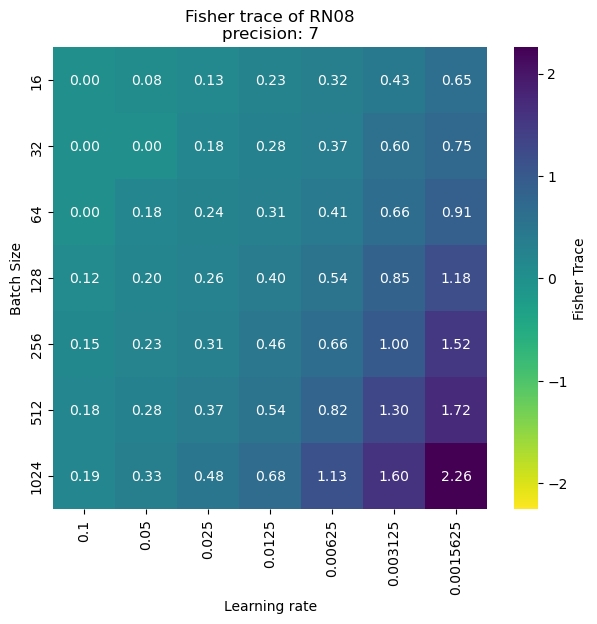

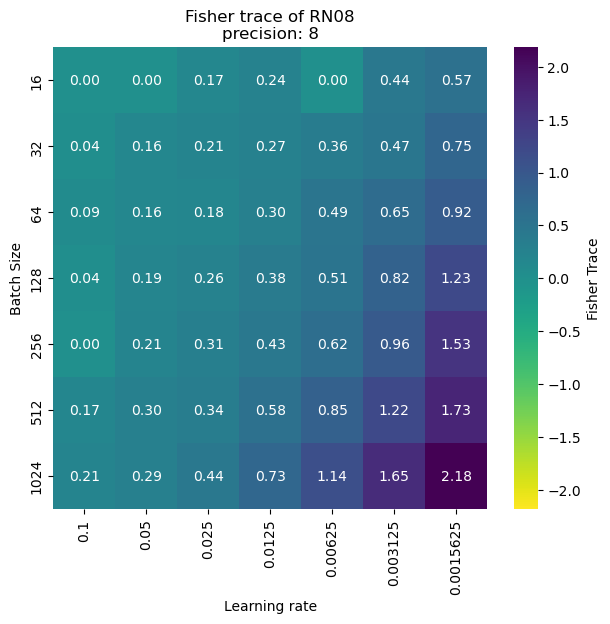

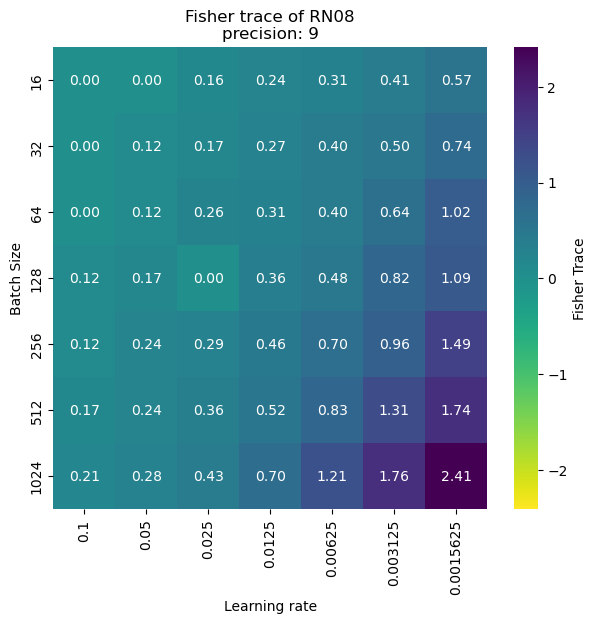

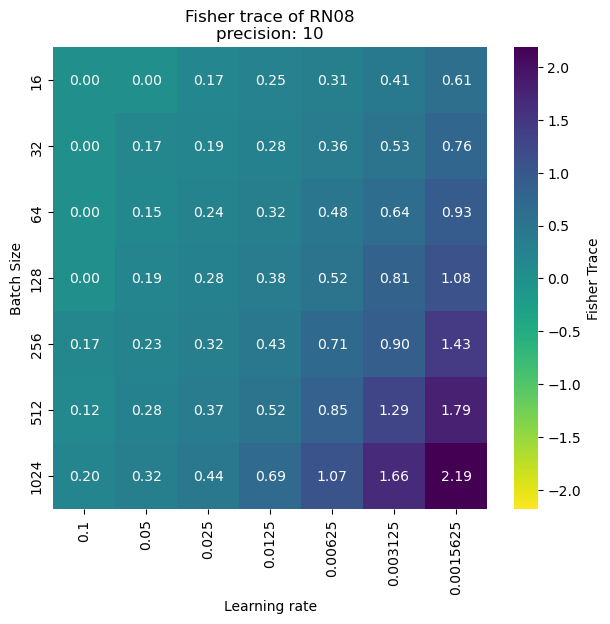

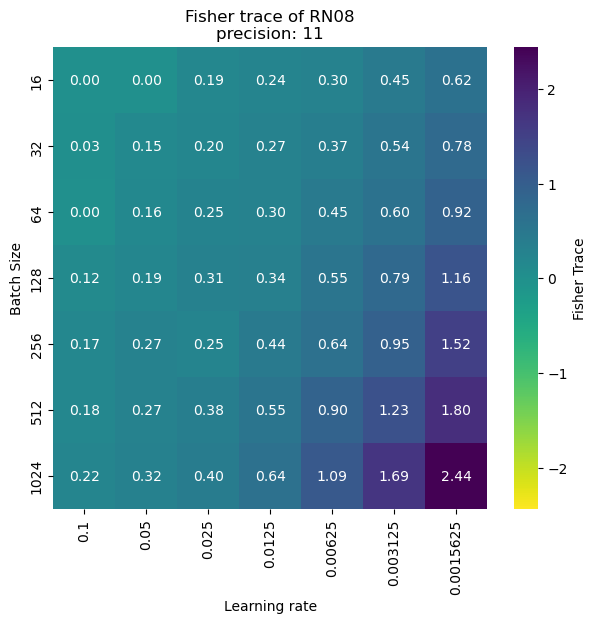

In [18]:
fisher_distribution = []
for p in precisions:
    fisher_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            
            path = os.path.join(
                DATA_PATH, 
                f'bs{bs}_lr{lr}/RN08_{p}b/'
            )
            result = -1
            try:
                result = read_file(path)
            except:
                print("Error: cannot open the file!")

            
            # build the heatmap matrix
            fisher_matrix[x, y] = result['avg_EF']
            
            # build the dataframe for further analysis
            fisher_distribution.append({
                'precision': p, 
                'avg_EF': result,
                'batch_size': str(bs),
                'learning_rate': str(lr),
            })
            
    # plot the heatmaps per precision
    fisher_matrix = pd.DataFrame(fisher_matrix, 
                                 index=batch_sizes, 
                                 columns=learning_rates)
    plot_2d_heatmap(np.cbrt(fisher_matrix), 
                    f'Fisher trace of RN08\nprecision: {p}', 
                    (-np.cbrt(fisher_matrix.max().max()), np.cbrt(fisher_matrix.max().max())),
                    'Learning rate',
                    'Batch Size',
                    'Fisher Trace',
                    cmap='viridis_r')
    

In [19]:
fisher_distribution_df = pd.DataFrame(fisher_distribution)
# export the CSV
fisher_distribution_df.to_csv("./results/rn08/fisher.csv", index=False)

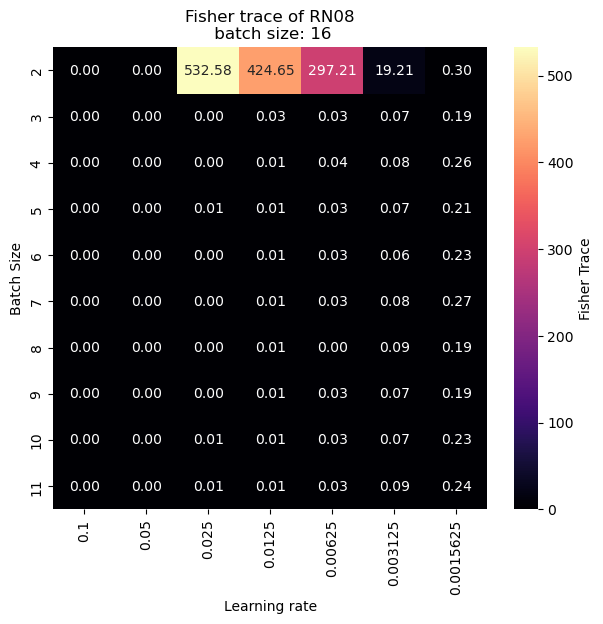

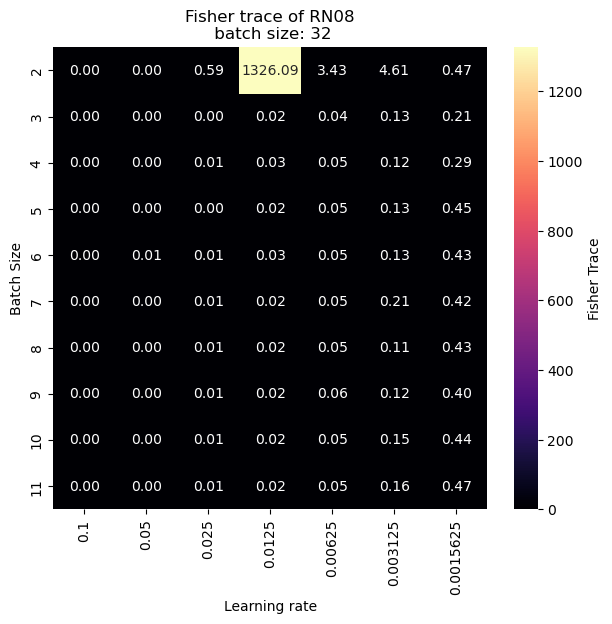

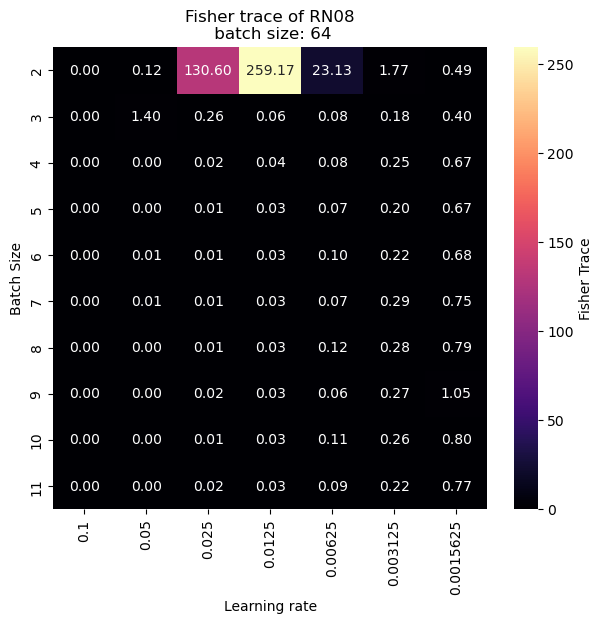

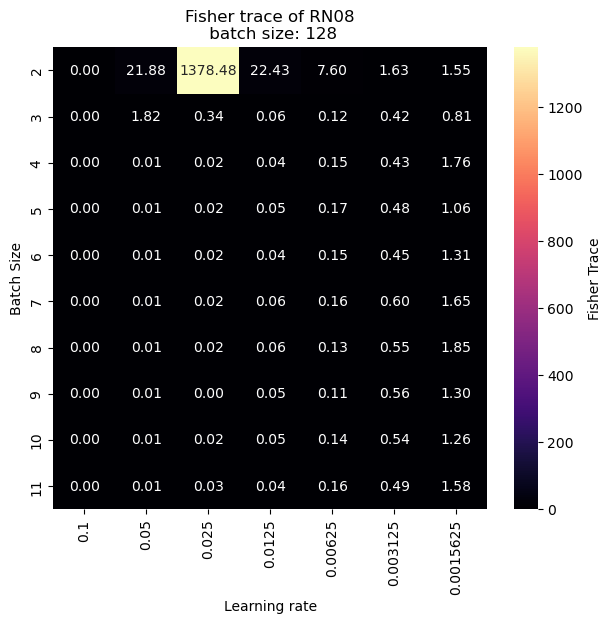

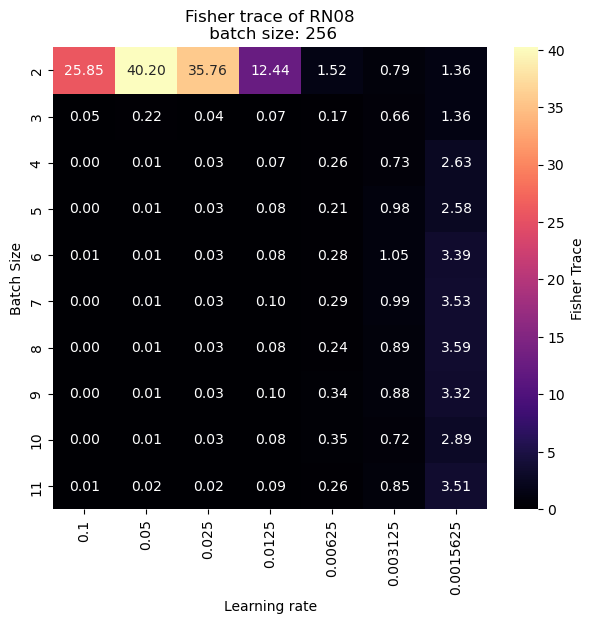

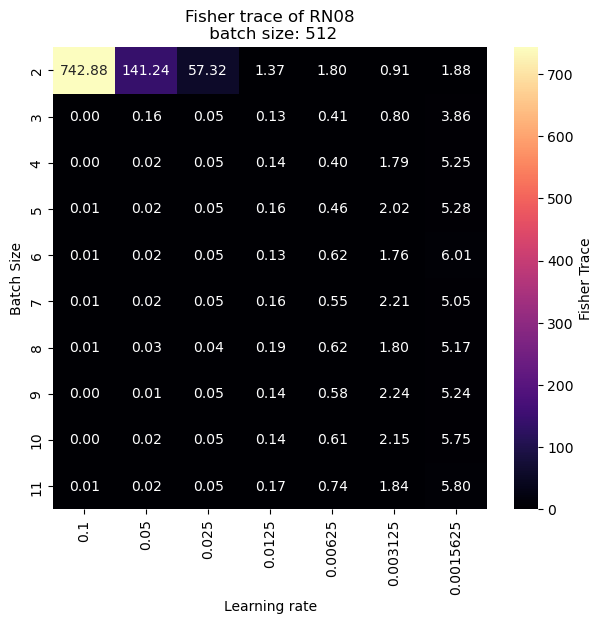

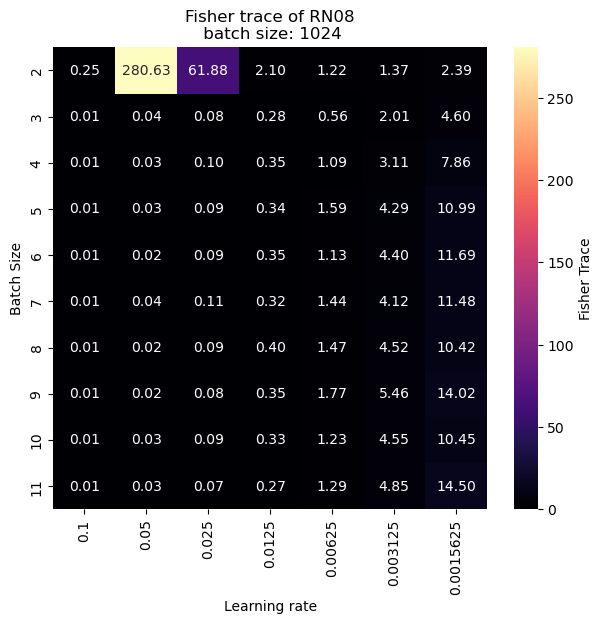

In [20]:
for bs in batch_sizes:
    fisher_matrix = np.zeros((len(precisions), len(learning_rates)))
    noise_matrix = np.zeros((len(precisions), len(learning_rates)))
    for y, lr in enumerate(learning_rates):
        for x, p in enumerate(precisions):
            
            path = os.path.join(
                DATA_PATH, 
                f'bs{bs}_lr{lr}/RN08_{p}b/'
            )
            result = -1
            try:
                result = read_file(path)
            except:
                print("Error: cannot open the file!")

            # build the heatmap matrix
            fisher_matrix[x, y] = result['avg_EF']
            
    # plot the heatmaps per precision
    fisher_matrix = pd.DataFrame(fisher_matrix, 
                             index=precisions, 
                             columns=learning_rates)
    plot_2d_heatmap(fisher_matrix, 
                    f'Fisher trace of RN08\n batch size: {bs}', 
                    (0, fisher_matrix.max().max()),
                    'Learning rate',
                    'Batch Size',
                    'Fisher Trace',
                    cmap='viridis_r')